# Monitoring beach litter with future engineers



The MSFD protocol {cite}`mlwguidance` has been used on Lake Geneva since November 2015. LProtocol based monitoring of beach litter statStart date each year: Nov 15,
End date each year: Nov 14,

includes years: 2015, 2016, 2017, 2018, 2019, 2020, 2021

The data for this analysis is the results from beach-litter surveys conducted in Switzerland, on the shores of Lac Léman.

The data was collected according to the protocol described here [https://www.plagespropres.ch/](https://www.plagespropres.ch/). In brief all visible data is collected along a beach within a measured distance from the waters edge. The width of the survey area depends on the terrain and the water level. The visible strand line or the nearest physical structure defines the width of a survey.

Surveys were conducted by the following organizations:

1. hammerdirt
2. Association pour le Sauvegarde du leman
3. Solid Waste Management Ecole Polytechnique Federal
4. Ecole International de Geneve
5. Precious plastic leman

This analysis is an open source document.

In [1]:
# sys, file and nav packages:
import os
import datetime as dt


# math packages:
import pandas as pd
import numpy as np
from scipy import stats
import datetime as dt 
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import percentileofscore


# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
import seaborn as sns
import matplotlib.gridspec as gridspec


# home brew utitilties
import resources.sr_ut as sut
# import resources.chart_kwargs as ck

# documenting
from IPython.display import display, HTML
from IPython.display import Markdown as md


# all the data
survey_data = pd.read_csv("resources/all_data_agg_foams_frags.csv")
# this is a duplicate entry
survey_data = survey_data[survey_data.location != "lac-leman-hammerdirt"]

survey_data["date"] = pd.to_datetime(survey_data["date"])

dfCodes = pd.read_csv("resources/codes_with_group_names_2015.csv")
dfBeaches = pd.read_csv("resources/beaches_with_land_use_rates.csv")

# map to code decriptions
dfCodes.set_index("code", inplace=True)
code_d = dfCodes["description"]

# map to material descriptions
mat_d = dfCodes["material"]

# leman and st sulpice data
coi = "Saint-Sulpice (VD)"

fd = survey_data[survey_data.water_name_slug == "lac-leman"].copy()

# the teams and the beaches they werre responsible for in each year
t_names = ["SWE", "PC", "EINT", "ASL", "SLR", "HD"]

teams_y1_4 = {
    "SWE":["tiger-duck-beach", "saint-sulpice", "rolle-plage", "plage-de-st-sulpice","parc-des-pierrettes"],
    "PC":["preverenges"],
    "EINT":["versoix",],
    "ASL":["baby-plage-geneva"],
    "SLR":["lacleman_vidy_santie", "lacleman_gland_lecoanets", "lacleman_gland_kubela"]
}

teams_y5_6 = {
    "SWE":["tiger-duck-beach", "saint-sulpice", "rolle-plage", "plage-de-st-sulpice","parc-des-pierrettes"],
    "PC":["preverenges", "maladaire", "vidy-ruines"],
    "EINT":["baby-plage-ii-geneve","rocky-plage"],
    "ASL":["baby-plage-geneva"],
    "SLR":[]
}

# hammerdirt was responsible for the surveys collected at the remaining locations
n_hd_y_1_4 = [*teams_y1_4[t_names[0]], *teams_y1_4[t_names[1]], *teams_y1_4[t_names[2]], *teams_y1_4[t_names[3]], *teams_y1_4[t_names[4]]]
n_hd_y_5_6 = [*teams_y5_6[t_names[0]], *teams_y5_6[t_names[1]], *teams_y5_6[t_names[2]], *teams_y5_6[t_names[3]], *teams_y5_6[t_names[4]]]

hd_y_1_4 = [x for x in fd.location.unique() if x not in n_hd_y_1_4]
hd_y_5_5 = [x for x in fd.location.unique() if x not in n_hd_y_5_6]

teams_y1_4.update({"HD":hd_y_1_4})
teams_y5_6.update({"HD":hd_y_5_5})

In [2]:
# set some parameters:
start_date = "2015-11-15"
end_date = "2021-11-14"

year_one = {"start_date":"2015-11-15", "end_date":"2016-11-14"}
year_two = {"start_date":"2016-11-15", "end_date":"2017-11-14"}
year_three = {"start_date":"2017-11-15", "end_date":"2018-11-14"}
year_four = {"start_date":"2018-11-15", "end_date":"2019-11-14"}
year_five = {"start_date":"2019-11-15", "end_date":"2020-11-14"}
year_six = {"start_date":"2020-11-15", "end_date":"2021-11-14"}

years = [year_one, year_two, year_three, year_four, year_five, year_six]
year_names = ["y1", "y2", "y3", "y4", "y5", "y6"]

fd["yx"] = ""
# make a column that has a value of year_names
def assign_a_survey_period(data, start_end, locs=[], year_name="y1"):
    """Slices the data by the start_end date and the locations in locs"""
    
    these_args = ((data["date"] >= start_end["start_date"])&(data["date"] <= start_end["end_date"])&(data["location"].isin(locs)))
    data.loc[these_args, "yx"]= year_name   

for i,name in enumerate(year_names):
    assign_a_survey_period(fd, years[i], locs=fd.location.unique(), year_name=name)    
    
for team in teams_y1_4:
    fd.loc[((fd.location.isin(teams_y1_4[team]))&(fd["date"] < "2019-11-14")), "team"]= team

for team in teams_y5_6:
    fd.loc[((fd.location.isin(teams_y5_6[team]))&(fd["date"] >= "2019-11-14")), "team"]= team

__samples per team per year__

In [3]:
a = fd.groupby(["yx", "team"], as_index=False).agg({"loc_date":"nunique", "quantity":"sum"})
asamps = a.pivot(columns="team", index="yx", values="loc_date").fillna(0).astype("int")
asamps.loc[:, "total"] = asamps.sum(axis=1)
asamps

team,ASL,EINT,HD,PC,SLR,SWE,total
yx,,,,,,,
y1,0,0,80,0,0,2,82
y2,0,1,20,0,17,2,40
y3,0,0,5,2,15,2,24
y4,0,0,0,0,0,2,2
y5,5,2,31,16,0,4,58
y6,6,1,18,16,0,3,44


__pieces per team per year__

In [4]:
aqty = a.pivot(columns="team", index="yx", values="quantity").fillna(0).astype("int")
aqty.loc[:, "total"] =  aqty.sum(axis=1)
aqty

team,ASL,EINT,HD,PC,SLR,SWE,total
yx,,,,,,,
y1,0,0,28007,0,0,2721,30728
y2,0,1490,9136,0,2526,1006,14158
y3,0,0,1785,203,1591,1534,5113
y4,0,0,0,0,0,306,306
y5,2719,167,9522,4701,0,1536,18645
y6,556,20,5735,2409,0,1766,10486


__median pieces per sample per team__

In [5]:
a["qs"] = a["quantity"]/a["loc_date"]
aqs = a.groupby("team").qs.median()
aqs

team
ASL     318.233333
EINT     83.500000
HD      350.087500
PC      150.562500
SLR     127.327451
SWE     545.833333
Name: qs, dtype: float64

## Variation in trash over time

The median survey value at the end of year 6 is less than all previous years, this corresponds to the results from the national survey that was terminated in May 2021. However, the 25th percentile from year one is less than the median from year six. This suggests that at least 50% of the samples from year six would have been below the 25th percentile of the first year. Given these results it is possible that there were reductions at specific locations, because 50% of the samples in year six fall below the IQR of year one.

### Year over year summary statistics

In [6]:
a_l = fd.groupby(["yx", "loc_date", "location", "team"], as_index=False).agg({"pcs_m":"sum", "quantity":"sum", })
a_l_summary = a_l.groupby("yx").agg({"loc_date":"nunique", "pcs_m":["median", "mean", "var"], "location":"nunique", "quantity":"sum"})
a_l_summary.columns = ["samples", "median", "mean","var", "locations", "pieces"]
a_l_summary["dispersion"] = a_l_summary["var"]/a_l_summary["mean"]
a_l_summary.round(2)

,samples,median,mean,var,locations,pieces,dispersion
yx,,,,,,,
y1,82,4.86,8.77,98.63,18,30728,11.24
y2,40,6.84,9.70,66.64,17,14158,6.87
y3,24,4.24,8.97,260.65,10,5113,29.06
y4,2,7.53,7.53,9.86,2,306,1.31
y5,58,5.70,9.69,147.84,20,18645,15.25
y6,44,4.00,7.41,110.46,16,10486,14.90


The dispersion (variance/mean) is greater than one for all years, prohibiting the use of a Poisson distribution but supporting the EUs decision to model outliers based on the Negative Binomial distribution{cite}`eubaseleines`.

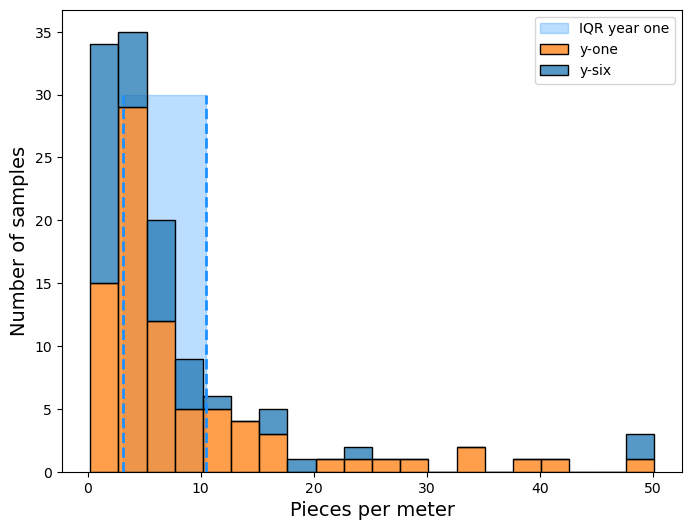

In [7]:
fig, ax = plt.subplots(figsize=(8,6))
data = fd[fd.yx.isin(["y1", "y6"])].groupby(["loc_date", "yx"], as_index=False).agg({"pcs_m":"sum"})
iq = fd[fd.yx == "y1"].groupby(["loc_date"]).pcs_m.sum().to_numpy()

sns.histplot(data=data, x="pcs_m", hue="yx", ax=ax, zorder=2, label="yx", multiple="stack")

ax.vlines([np.percentile(iq, 25), np.percentile(iq, 75)], ymin=0, ymax=30, linestyle="dashed", color="dodgerblue", zorder=3, linewidths=2)
ax.fill_between([np.percentile(iq, 25), np.percentile(iq, 75)], y1=0, y2=30, color="dodgerblue", alpha=0.3, zorder=0, label="IQR year one")
h,l = ax.get_legend_handles_labels()
hs = h[0]
nl = [l[0], "y-one", "y-six"]
plt.legend(h,nl)

ax.set_ylabel("Number of samples", fontsize=14)
ax.set_xlabel("Pieces per meter", fontsize=14)

plt.show()

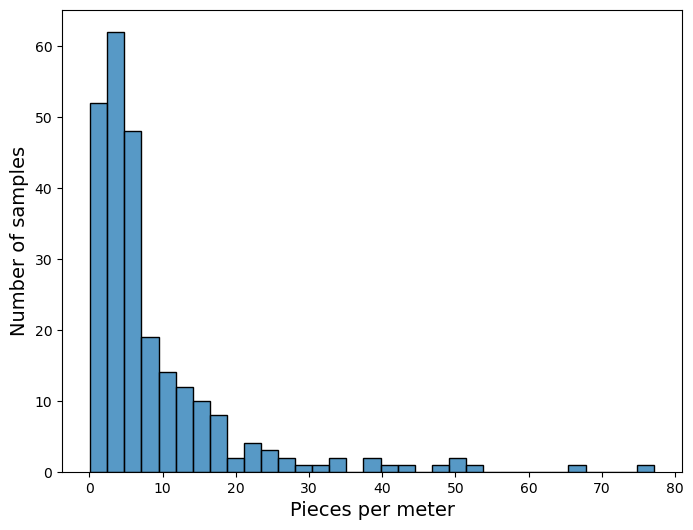

In [8]:
fig, ax = plt.subplots(figsize=(8,6))
data = fd.groupby(["loc_date"], as_index=False).agg({"pcs_m":"sum"})

sns.histplot(data=data, x="pcs_m",ax=ax, zorder=2)

ax.set_ylabel("Number of samples", fontsize=14)
ax.set_xlabel("Pieces per meter", fontsize=14)

plt.show()

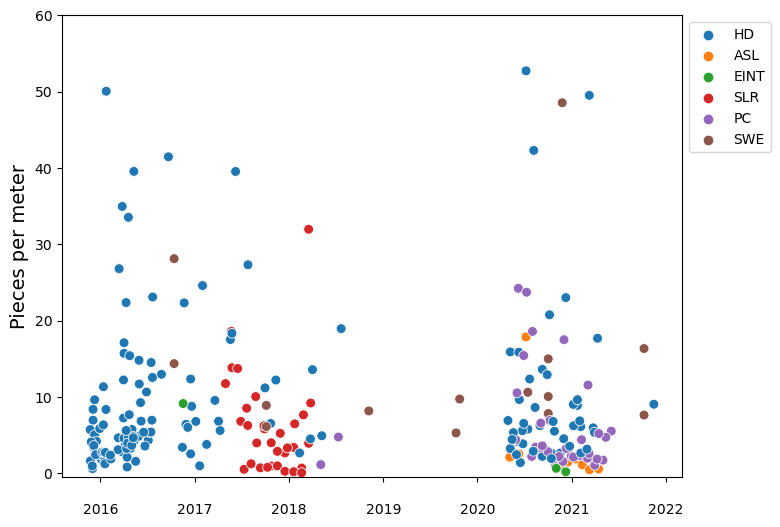

In [9]:
fig, ax = plt.subplots(figsize=(8,6))
a_locdate = fd.groupby(["loc_date","date", "location", "team"], as_index=False).agg({"pcs_m":"sum", "quantity":"sum", })
a_locdate["date"]=pd.to_datetime(a_locdate["date"])

ylimit=60
sns.scatterplot(data=a_locdate, x="date", y="pcs_m", s=50, hue="team")
ax.set_xlabel("")
days = mdates.DayLocator(interval=7)

ax.tick_params(axis="x", which="major", pad=15)

ax.set_ylim(-.5,60)
ax.set_ylabel("Pieces per meter", fontsize=14)
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

### Survey total summary

In [10]:
a_locdate.pcs_m.describe()

count    250.000000
mean       8.904040
std       10.964358
min        0.100000
25%        2.690000
50%        5.375000
75%       10.077500
max       77.100000
Name: pcs_m, dtype: float64

__Below__ The year over year survey results for Lac Léman. There are surveys in each year since 2015

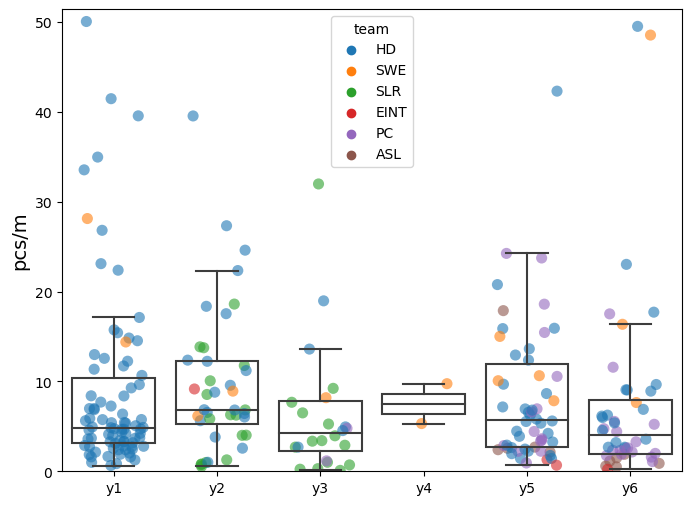

In [11]:
a_locdate = fd.groupby(["yx", "loc_date","date", "location", "team"], as_index=False).agg({"pcs_m":"sum", "quantity":"sum", })
a_locdate["date"]=pd.to_datetime(a_locdate["date"])

PROPS = {
    'boxprops':{'facecolor':'none'},   
}

fig, ax = plt.subplots(figsize=(8,6))

sns.boxplot(data=a_locdate, x="yx", y="pcs_m", showfliers=False, ax=ax, **PROPS, zorder=2, order=year_names)
sns.stripplot(data=a_locdate, x="yx", y="pcs_m", ax=ax, size=8, alpha=.6,hue="team", jitter=.3, zorder=0, order=year_names)
ylimit = np.quantile(a_locdate.pcs_m.values, .99)
ax.set_ylim(0, ylimit)
ax.set_ylabel("pcs/m", fontsize=14)
ax.set_xlabel("")

plt.show()

In [12]:
axis_limits = ylimit
statement = f"Values greater than {np.round(ylimit, 2)} pcs/m not shown, the 99th percentile."
md(statement)

Values greater than 51.42 pcs/m not shown, the 99th percentile.

### Year over year cumulative distribution

Considering sample years with more than two observations. The highest median was in year 2 and the highest mean was recorded in years 2 and 5  but the maximum value was recorded in year 3 by SWE students at tiger-duck-beach. The dispersion is lowest in year two. The third year has the lowest number of samples and locations but the highest dispersion.  Three locations are responsible for 68% of all samples in year three. The median survey value of these three locations ranges from 0.29 to 6.5, the maximum survey value in year three was 77pcs/m. Differences of this magnitude are regular occurrences, the high variance of beach litter surveys was noted when the EU published guidelines on determining baseline values and thresholds. {cite}`eubaselines` 

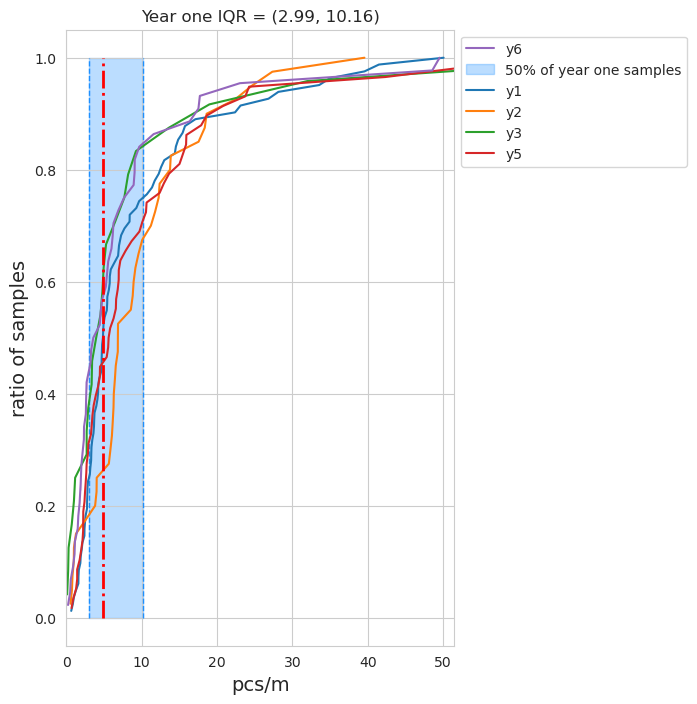

In [13]:
ecdfs = [ECDF(a_locdate[a_locdate.yx == x].pcs_m.values) for x in year_names]
sns.set_style("whitegrid")


fig, ax = plt.subplots(figsize=(5,8))

ax.set_xlim(0, ylimit)


for i, name in enumerate(year_names):
    if i == 0:
        somdata=ecdfs[0].x
        median = np.quantile(somdata, .5)
        lower25 = np.quantile(somdata, .25)
        upper25 = np.quantile(somdata, .75)
        ax.vlines([lower25, upper25], ymin=0, ymax=1, linestyle="dashed", color="dodgerblue", zorder=1, linewidths=1)
        ax.fill_between([lower25, upper25], y1=0, y2=1, color="dodgerblue", alpha=0.3, zorder=0, label="50% of year one samples")
        ax.vlines(median, ymin=0, ymax=1, color="red", linestyle="dashdot", linewidths=2, alpha=1, zorder=3)
        
        
    if i != 3:
        sns.lineplot(x=ecdfs[i].x, y=ecdfs[i].y, ax=ax, label=name, zorder=2)
        
    else:
        pass
handles, labels = ax.get_legend_handles_labels()
ax.set_xlabel("pcs/m", fontsize=14)
ax.set_ylabel("ratio of samples", fontsize=14)

n_handles = [handles[-1], *handles[:-1]]
n_labels = [labels[-1], *labels[:-1]]    
plt.legend(n_handles, n_labels, bbox_to_anchor=(1,1), loc="upper left")
plt.title(f"Year one IQR = {round(lower25, 2), round(upper25, 2)}")
plt.show()

### Comparison between the survey groups

The innerquartile range from y-one accounts for 50% of the survey results from SLR and 59% of the results from PC. The 25^th percentile is much lower in both cases (Fig. 5). The groups also represent regional clusters. The year one surveys were primarily from the Haut Lac, SLR surveys are primarily in the Grand Lac and PC surveys are between the Grand Lac and the Haut Lac. The variance between years and groups has a part that can be attributed to location.

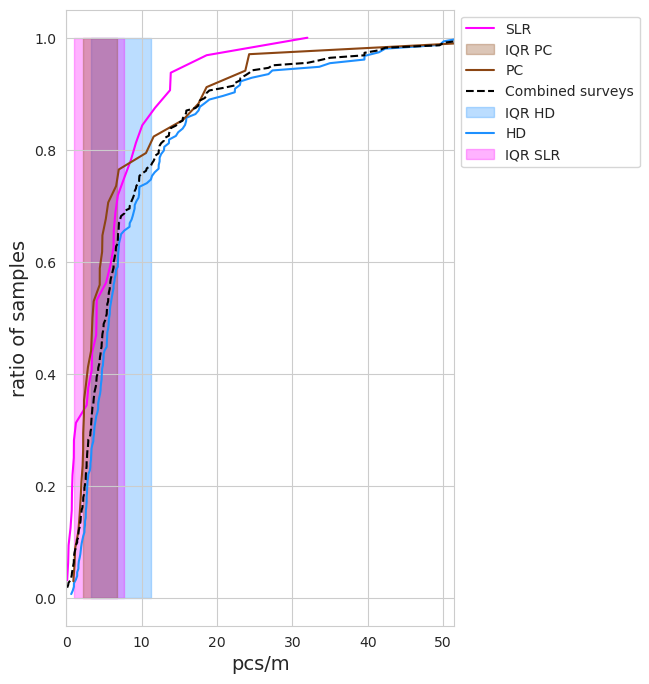

In [14]:
ecdfs = [ECDF(a_locdate[a_locdate.team == x].pcs_m.values) for x in ["HD", "SLR", "PC"]]
sns.set_style("whitegrid")
colors = ["dodgerblue", "magenta", "saddlebrown"]


fig, ax = plt.subplots(figsize=(5,8))

ax.set_xlim(0, ylimit)

iqrs_by_group = {}

for i, name in enumerate(["HD", "SLR", "PC"]):
    somdata=ecdfs[i].x
    ecdfs.append(somdata)
    median = np.quantile(somdata, .5)
    lower25 = np.quantile(somdata, .25)
    upper25 = np.quantile(somdata, .75)
    iqrs_by_group.update({name:[lower25, median, upper25]})
    
    
    ax.fill_between([lower25, upper25], y1=0, y2=1, color=colors[i], alpha=0.3, zorder=0, label=f"IQR {name}")
    sns.lineplot(x=ecdfs[i].x, y=ecdfs[i].y, ax=ax, label=name, zorder=1, color=colors[i])
        
combined = ECDF([*ecdfs[0].x, *ecdfs[1].x, *ecdfs[2].x])

sns.lineplot(x=combined.x, y=combined.y, ax=ax, label="Combined surveys", zorder=2, linestyle="dashed", color="black")

handles, labels = ax.get_legend_handles_labels()
ax.set_xlabel("pcs/m", fontsize=14)
ax.set_ylabel("ratio of samples", fontsize=14)

n_handles = [*handles[-4:], *handles[:-4]] # handles
n_labels =  [*labels[-4:], *labels[:-4]] # labels
plt.legend(n_handles, n_labels, bbox_to_anchor=(1,1), loc="upper left")
plt.show()

__The number of locations below the 25th and above the 75th percentile__

Consider the results from year one as a base year and recall that HD was responsible for 80 of the 82 surveys. SLR has 12 samples below the IQR from year one and 5 above the IQR. 50% of SLR surveys fall within the IQR of year one. PC had 15 below the IQR and seven above or 59% of all PC surveys fall within the IQR of year one.

In [15]:
slr = ecdfs[1].x
slr_less = (len(slr[slr < 3.265]), max(slr[slr <3.265]))
slr_more = (len(slr[slr > 11.3225]), max(slr[slr > 3.265]))


a_l = fd.groupby(["team", "loc_date"], as_index=False).agg({"pcs_m":"sum"})
a_l.groupby("team").agg({"loc_date":"nunique", "pcs_m":"median"})
a_l.rename(columns={"loc_date":"samples"}, inplace=True)

pc = ecdfs[2].x
pcl = (len(pc[pc<3.265]), max(pc[pc < 3.265]))
pcm = (len(pc[pc > 11.3225]), max(pc[pc > 11.3265]))
# print(pcl)
# print(pcm)
# print(1-14/34)

## Composition over time

Year over percent of total of the top ten codes on Lake Geneva

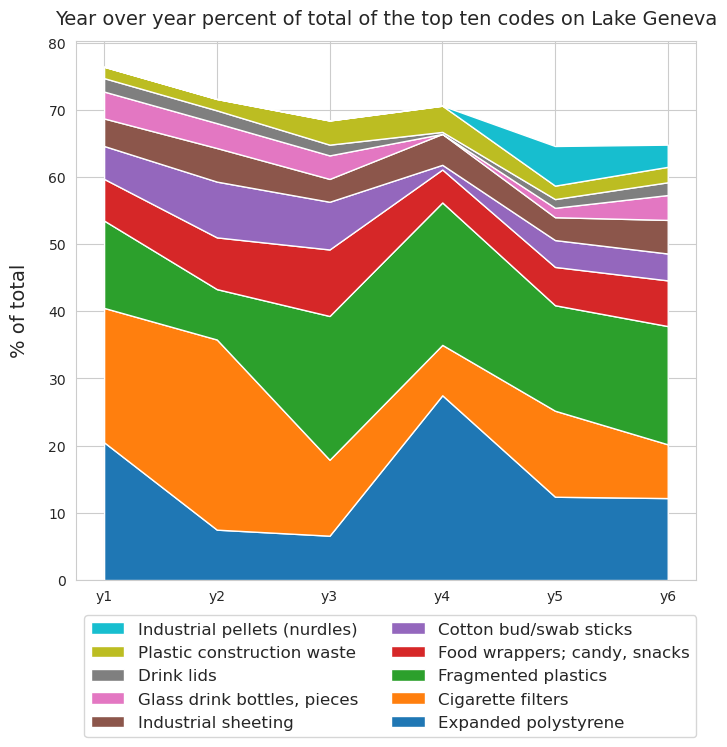

In [16]:
# definition of Gfoams
some_foams = ['G81', 'G82', 'G83', 'G911', 'G912']
yellow_foams = ['G74', 'G909', 'G910']

#definition of Gfrags


ten_yoy = fd.groupby(["yx","code"], as_index=False).quantity.sum()
yx_totals = fd.groupby("yx").quantity.sum()

lake_code_totals = fd.groupby("code").quantity.sum()
lake_top_ten = lake_code_totals.sort_values(ascending=False)[:10].index
for a_year in ten_yoy.yx.unique():
    ten_yoy.loc[ten_yoy.yx==a_year, "p"] = ((ten_yoy.quantity/yx_totals.loc[a_year])*100).round(1)
    
p_total_yoy = ten_yoy[ten_yoy.code.isin(lake_top_ten)].pivot(index="code", columns="yx", values="p")
chart = p_total_yoy.sort_values(by="y1", ascending=False)

fig, ax = plt.subplots(figsize=(8,7))

ax.stackplot(chart.columns.values, chart.values, labels=chart.index.values)
h, l = ax.get_legend_handles_labels()
ls=[dfCodes.loc[x].description for x in l]
ax.legend(h[::-1], ls[::-1], bbox_to_anchor=(0,-.05), loc="upper left", ncol=2, fontsize=12)
ax.set_title("Year over year percent of total of the top ten codes on Lake Geneva", pad=12, fontsize=14)
ax.set_ylabel("% of total", fontsize=14, labelpad=14)
plt.show()

Table of values year over year percent of total of the top ten codes on Lake Geneva

In [17]:
chart.loc["total"] = chart.sum(axis=0)
chart

yx,y1,y2,y3,y4,y5,y6
code,,,,,,
Gfoam,20.5,7.5,6.6,27.5,12.4,12.2
G27,20.0,28.3,11.3,7.5,12.8,8.0
Gfrags,13.0,7.5,21.4,21.2,15.7,17.6
G30,6.2,7.7,9.9,4.9,5.7,6.8
G95,4.9,8.3,7.1,0.7,4.0,4.0
G67,4.1,5.0,3.4,4.6,3.4,5.0
G200,4.0,3.7,3.5,0.0,1.4,3.7
G21,2.0,1.9,1.6,0.3,1.3,1.9
G89,1.7,1.7,3.6,3.9,2.0,2.3


Year over year qauntity of the top ten objects Lake Geneva.

In [18]:
p_total_yoy = ten_yoy[ten_yoy.code.isin(lake_top_ten)].pivot(index="code", columns="yx", values="quantity")
p_yoy = p_total_yoy.sort_values(by="y1", ascending=False)
p_yoy.loc["total"] = p_yoy.sum(axis=0)
p_yoy

yx,y1,y2,y3,y4,y5,y6
code,,,,,,
Gfoam,6298,1067,339,84,2317,1280
G27,6152,4006,578,23,2390,836
Gfrags,3985,1066,1092,65,2920,1841
G30,1913,1097,508,15,1068,717
G95,1498,1171,362,2,754,424
G67,1246,710,174,14,630,522
G200,1234,529,179,0,261,383
G21,602,275,81,1,241,194
G89,524,245,186,12,366,246


### Composition over time Saint Sulpice

The top ten from all samples in Saint-Sulpice year over year. 

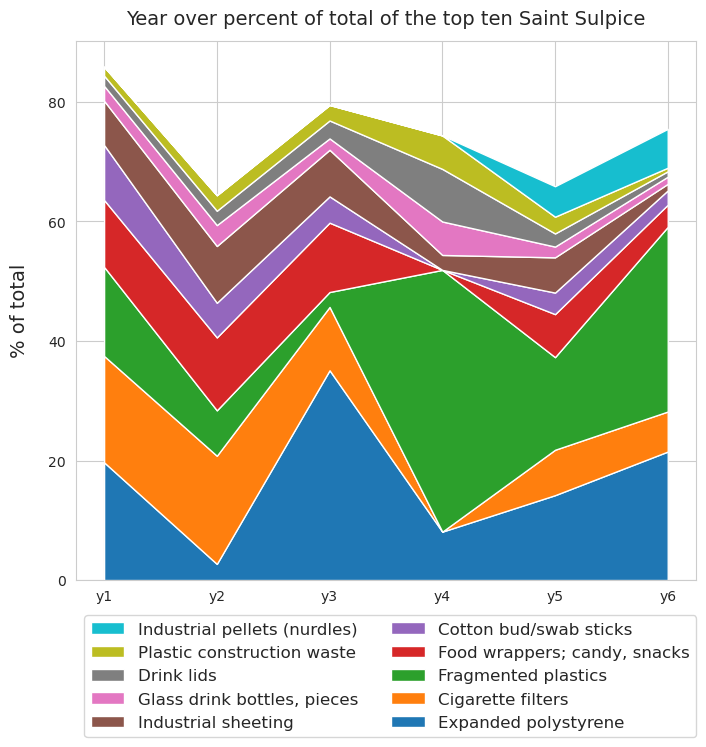

In [19]:
sp_beaches = dfBeaches[dfBeaches.city == "Saint-Sulpice (VD)"].slug.values
swe_cts = fd[fd.location.isin(sp_beaches)].copy()

swe_ten_yoy = swe_cts.groupby(["yx","code"], as_index=False).quantity.sum()
swe_yx_totals = swe_cts.groupby("yx").quantity.sum()

swe_code_totals = swe_cts.groupby("code").quantity.sum()
swe_top_ten = swe_code_totals.sort_values(ascending=False)[:10].index
for a_year in swe_ten_yoy.yx.unique():
    swe_ten_yoy.loc[swe_ten_yoy.yx==a_year, "p"] = ((swe_ten_yoy.quantity/swe_yx_totals.loc[a_year])*100).round(1)
    
swe_p_total_yoy = swe_ten_yoy[swe_ten_yoy.code.isin(swe_top_ten)].pivot(index="code", columns="yx", values="p")
charts = swe_p_total_yoy.sort_values(by="y1", ascending=False)

fig, ax = plt.subplots(figsize=(8,7))

ax.stackplot(charts.columns.values, charts.values, labels=chart.index.values)
h, l = ax.get_legend_handles_labels()
ls=[dfCodes.loc[x].description for x in l]
ax.legend(h[::-1], ls[::-1], bbox_to_anchor=(0,-.05), loc="upper left", ncol=2, fontsize=12)
ax.set_title("Year over percent of total of the top ten Saint Sulpice", pad=12, fontsize=14)
ax.set_ylabel("% of total", fontsize=14, labelpad=14)
plt.show()

_Table of values values percent of total of the top ten Saint Sulpice_

In [20]:
charts["description"] = charts.index.map(lambda x: dfCodes.loc[x].description)
charts.loc["total", charts.columns[:-1]] = charts.sum(axis=0)
charts

yx,y1,y2,y3,y4,y5,y6,description
code,,,,,,,
Gfrags,19.7,2.7,35.1,8.1,14.2,21.5,Fragmented plastics
G200,17.8,18.1,10.6,0.0,7.6,6.7,"Glass drink bottles, pieces"
Gfoam,14.9,7.6,2.5,43.8,15.5,30.9,Expanded polystyrene
G27,11.2,12.2,11.6,0.0,7.2,3.7,Cigarette filters
G95,9.2,5.8,4.4,0.0,3.6,2.4,Cotton bud/swab sticks
G30,7.4,9.5,7.8,2.5,5.9,1.1,"Food wrappers; candy, snacks"
G100,2.5,3.5,1.9,5.6,1.8,1.2,Medical; containers/tubes/ packaging
G67,1.7,2.4,3.0,8.8,2.2,0.9,Industrial sheeting
G89,1.5,2.6,2.6,5.6,2.8,0.6,Plastic construction waste


## Site specific results

As mentioned previously the SWE group is the only group that has surveys in each year in the same municipality. Of the beaches surveyed by SWE, two are separated by a short walk through a residential neighborhood. The year over year results from Plage de St-Sulpice (PS) and Parc des Pierrettes (PP) were compared to the base year median set in sampling period one. Both beaches had results greater than the lake median in each year but the pcs/m at each site declined year over year with respect to the first sample. This corresponds with the observations in the previous section reference y-one and y-six. If there is a general trend it appears that these two locations are following it.

In [21]:
boi = ["plage-de-st-sulpice","parc-des-pierrettes"]
sp_ld = fd[fd.location.isin(boi)].groupby(["yx", "loc_date", "location"], as_index=False).agg({"pcs_m":"sum", "quantity":"sum", })
fdsp = fd[fd.location.isin(boi)].copy()

# this the median value from year one for the lake
sp_ld["dif-by"] = sp_ld.pcs_m - 4.86

# substract the first year from all subsequent years:
sp_ld.loc[sp_ld.location==boi[0], "dif-y1"] = (sp_ld.pcs_m - 28.13).round(2)
sp_ld.loc[sp_ld.location==boi[1], "dif-y1"] = (sp_ld.pcs_m - 14.39).round(2)
sp_ld

,yx,loc_date,location,pcs_m,quantity,dif-by,dif-y1
0,y1,"('parc-des-pierrettes', '2016-10-13')",parc-des-pierrettes,14.39,693,9.53,0.00
1,y1,"('plage-de-st-sulpice', '2016-10-13')",plage-de-st-sulpice,28.13,2028,23.27,0.00
2,y2,"('parc-des-pierrettes', '2017-10-05')",parc-des-pierrettes,6.15,258,1.29,-8.24
3,y2,"('plage-de-st-sulpice', '2017-10-05')",plage-de-st-sulpice,8.92,748,4.06,-19.21
4,y4,"('parc-des-pierrettes', '2019-10-10')",parc-des-pierrettes,5.31,160,0.45,-9.08
5,y5,"('parc-des-pierrettes', '2020-10-01')",parc-des-pierrettes,10.08,464,5.22,-4.31
6,y5,"('plage-de-st-sulpice', '2020-10-01')",plage-de-st-sulpice,7.85,326,2.99,-20.28
7,y6,"('plage-de-st-sulpice', '2021-10-07')",plage-de-st-sulpice,7.65,304,2.79,-20.48


*__Above:__ The difference in survey results from the base year (diff-by) and the first sample (diff-y1) at Plage de St Sulpice and Parc des Pierettes.* 

Upon collection and sorting, the quantity of each material type was input into the database based on the MLW code classification. Figure x and y (quantities presented in Appendix – Table 5 & 6) show the segmented data for the litter collected at Plage de St-Sulpice (PS) and Parc des Pierrettes (PP) beaches.  

Scrutinizing the data further, it can be seen that the majority of the litter is composed of plastics that accounts for approximately 79 and 88% for both PS and PP, respectively. 

In [22]:
fdsp["material"] = fdsp.code.map(lambda x: mat_d[x])
mats = fdsp.groupby(["location", "material"], as_index=False).quantity.sum()
mats.loc[mats.location == boi[0], "% of total"] = round((mats.quantity/mats.loc[mats.location == boi[0]].quantity.sum())*100, 2)
mats.loc[mats.location == boi[1], "% of total"] = round((mats.quantity/mats.loc[mats.location == boi[1]].quantity.sum())*100, 2)
mats.pivot(columns="location", index="material", values="% of total")

location,parc-des-pierrettes,plage-de-st-sulpice
material,,
Chemicals,0.06,0.00
Cloth,0.95,0.44
Glass,7.30,25.48
Metal,1.59,3.05
Paper,1.21,0.50
Plastic,88.19,69.11
Rubber,0.38,0.91
Unidentified,0.00,0.00
Wood,0.32,0.50


<!-- Taking the top 10 litter items from PP and PS, and organising them along with the total surveyed quantities, a comparison of the interquartile range and the outliers is made (Fig. 10). Surprisingly, the items collected, although made of similar material (predominantly artificial polymeric material), are not from the same source.  Litter G100, G200, G30, G87 and G95, are all outliers and represent an ‘above average’ accumulation on the shore of PS (Codes and Description available in Appendix – Table 7). The results for PP are similar in that the most common objects all exceed the median of the combined results of HD and SLR.
When all objects are considered, the median survey result at PS (18.5) and PP (10.25) place these locations in the 88th and 73rd percentile rankings respectively with respect to the combined results. Suggesting that there was a better chance of observing elevated litter densities at these two beaches when compared to the rest of the locations. -->



Via categorising the AL in accordance to the MLW, and comparing the total surveyed data, it is shown that even with the appearance of the same physical material, in this case predominantly composed of polymeric material, the source it originates from is different along with the quantity. Most probably, the reason for the difference could be the flow in the lake. It takes approximately 10 years for the volume of water to pass through the lake (residence time), and at the same time seasonal fluctuation and the direction of the beach can affect where and by how much the waste accumulates. For instance, the PS beach is somewhat sheltered from the directional flow of water, and thus there is a higher potential of debris accumulating there over time.  PP is mostly parallel to the flow and thus, it attracts a different type of waste. Thus, a quantitative assessment as such helps gain insight as to how ‘healthy’ the shoreline is when used for recreational activities based on the location relative to the flow. 

In [23]:
code_summary = fdsp[fdsp.yx.isin(["y1", "y2", "y5"])].groupby(["location", "code", "groupname"], as_index=False).quantity.sum()
for code in code_summary.code.unique():
    code_summary.loc[code_summary.code == code, "description"] = code_d.loc[code]
    code_summary.loc[code_summary.code == code, "material"] =  mat_d.loc[code]

c_sum = []
for each_beach in boi:
    tten = code_summary[code_summary.location ==each_beach].sort_values(by="quantity", ascending=False)[:10]
    mat = code_summary[code_summary.location ==each_beach][["material", "quantity"]].groupby("material", as_index=False).quantity.sum().sort_values(by="quantity", ascending=False)
    groups = code_summary[code_summary.location ==each_beach][["groupname", "quantity"]].groupby("groupname", as_index=False).quantity.sum().sort_values(by="quantity", ascending=False)
    
    c_sum.append([tten, mat, groups])

### Saint Sulpice:

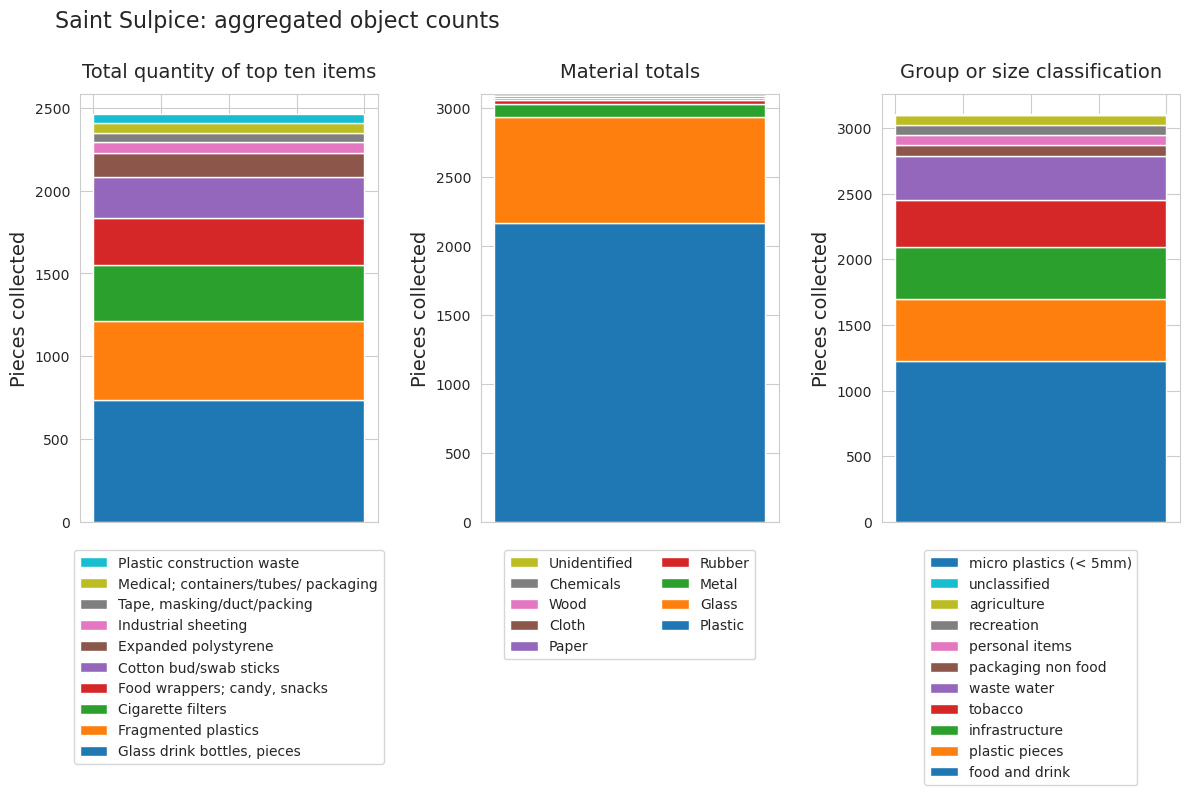

In [24]:
tdata = c_sum[0][0][["description", "quantity"]].values

matdata = c_sum[0][1].values

gdata = c_sum[0][2].values


def a_simple_stack(vals, ax, bbox=(.5, -.05), loc="upper center", title="atitle", ylabel="ylabel", ncol=1):
    

    bottom = 0
    for each_value in vals:
        ax.bar(0, each_value[1], bottom=bottom, label=each_value[0])
        bottom += each_value[1]

    ax.tick_params(axis='x',  which='both',  bottom=False, labelbottom=False)
    h, ls = ax.get_legend_handles_labels()
    ax.legend(h[::-1], ls[::-1], bbox_to_anchor=bbox, loc=loc, ncol=ncol,fontsize=10)
    ax.set_title(title, pad=12, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)

    
titleone="Total quantity of top ten items"
ylabelone = "Pieces collected"

titletwo = "Material totals"
titlethree= "Group or size classification"

    
fig, ax = plt.subplots(1,3, figsize=(12,8))

a_simple_stack(tdata, ax[0], title=titleone, ylabel=ylabelone)
a_simple_stack(matdata, ax[1], title=titletwo, ylabel=ylabelone, ncol=2)
a_simple_stack(gdata, ax[2], title=titlethree, ylabel=ylabelone)

fig.suptitle("Saint Sulpice: aggregated object counts", fontsize=16, y=1, ha="left", x=0.05)
plt.tight_layout()



plt.show()


In [25]:
c_sum[0][0][["description", "quantity"]]

,description,quantity
328,"Glass drink bottles, pieces",737
459,Fragmented plastics,475
346,Cigarette filters,341
350,"Food wrappers; candy, snacks",279
452,Cotton bud/swab sticks,252
458,Expanded polystyrene,142
382,Industrial sheeting,65
403,"Tape, masking/duct/packing",59
232,Medical; containers/tubes/ packaging,57
405,Plastic construction waste,52


### Parc des Pierettes

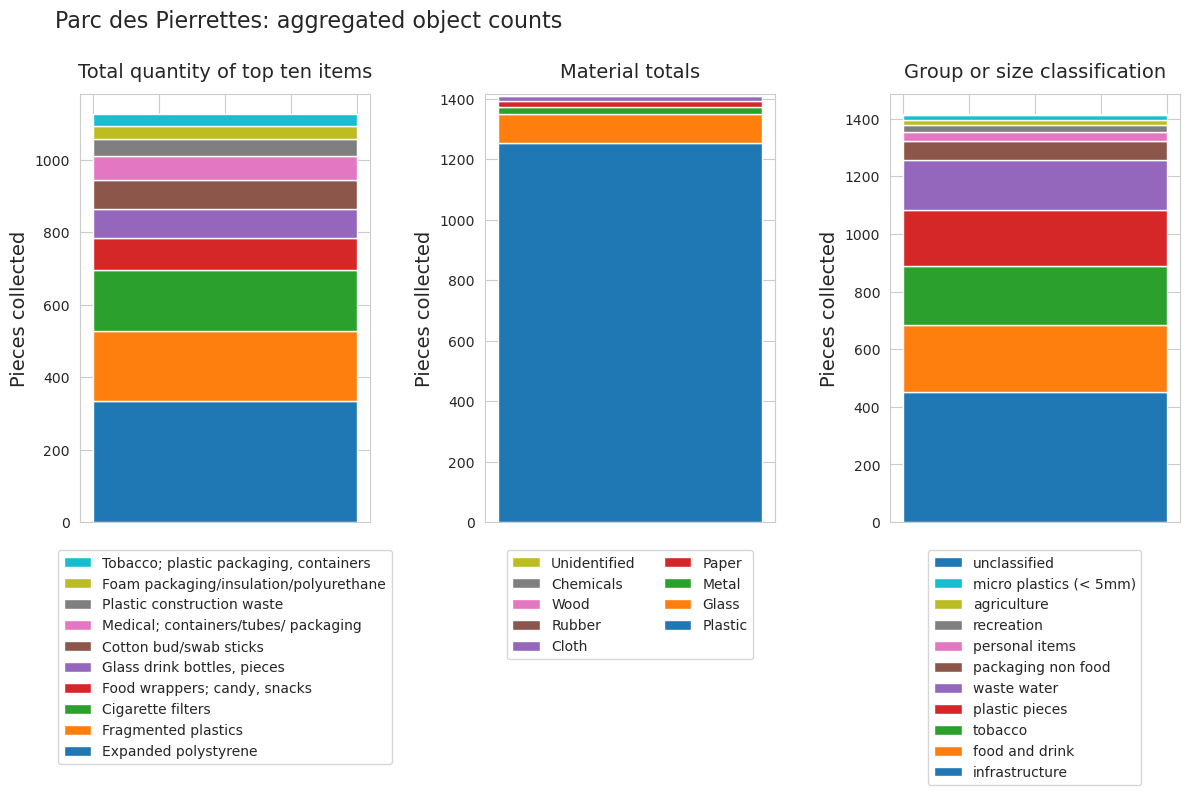

In [26]:
sp_ld_summary = sp_ld[(sp_ld.location == boi[1])&(sp_ld.yx.isin(["y1", "y2", "y5"]))].copy()
sp_sum = sp_ld_summary.groupby("yx", as_index=False).agg({"pcs_m":"median","quantity":"sum"})

tdata = c_sum[1][0][["description", "quantity"]].values

matdata = c_sum[1][1].values

gdata = c_sum[1][2].values

titleone="Total quantity of top ten items"
ylabelone = "Pieces collected"

titletwo = "Material totals"
titlethree= "Group or size classification"

    
fig, ax = plt.subplots(1,3, figsize=(12,8))

a_simple_stack(tdata, ax[0], title=titleone, ylabel=ylabelone)
a_simple_stack(matdata, ax[1], title=titletwo, ylabel=ylabelone, ncol=2)
a_simple_stack(gdata, ax[2], title=titlethree, ylabel=ylabelone)

fig.suptitle("Parc des Pierrettes: aggregated object counts", fontsize=16, y=1, ha="left", x=0.05)
plt.tight_layout()



plt.show()

In [27]:
c_sum[1][0][["description", "quantity"]]

,description,quantity
228,Expanded polystyrene,333
229,Fragmented plastics,195
116,Cigarette filters,169
120,"Food wrappers; candy, snacks",86
98,"Glass drink bottles, pieces",80
222,Cotton bud/swab sticks,80
2,Medical; containers/tubes/ packaging,66
175,Plastic construction waste,49
170,Foam packaging/insulation/polyurethane,34
114,"Tobacco; plastic packaging, containers",33


#### Material totals

At PS all the most common items had lower survey values when compared to year one, at PP it was 6 out of 10. In both cases cigarette ends and broken glass are both less in the last survey year. This also corresponds to the general trend observed in the national report. St Sulpice is moderately dense and would be considered urban under most circumstances.

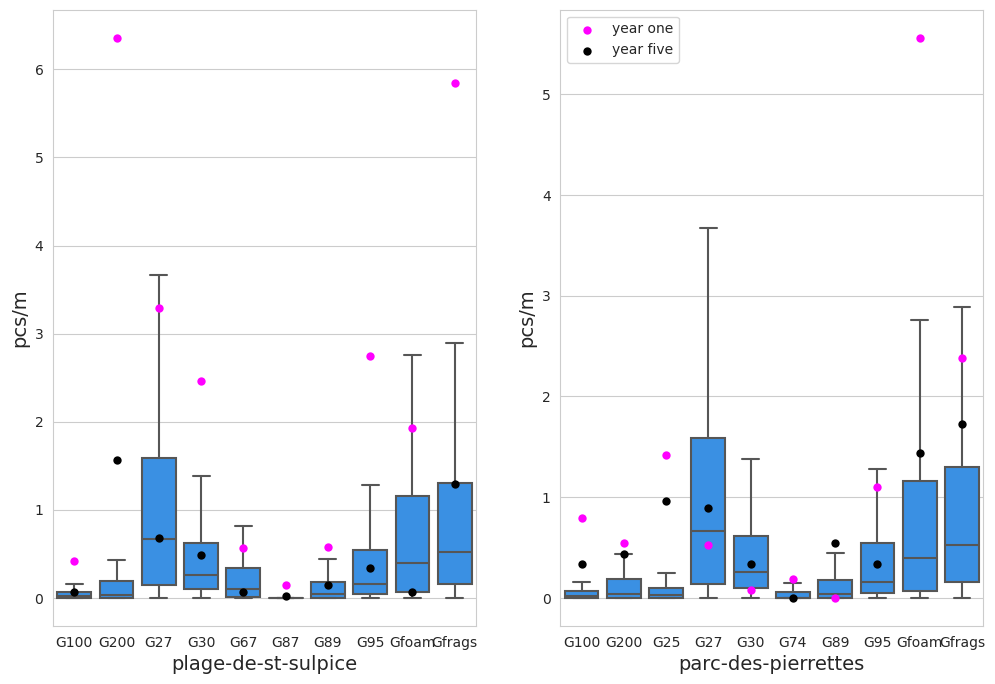

In [28]:
tsp = fd[fd.location == boi[0]].groupby("code", as_index=False).quantity.sum().sort_values(by="quantity", ascending=False)[:10]
tpp = fd[fd.location == boi[1]].groupby("code", as_index=False).quantity.sum().sort_values(by="quantity", ascending=False)[:10]

xaxone = fd[fd.code.isin(tsp.code.values)].groupby(["loc_date", "code"], as_index=False).pcs_m.sum()
sone =  fd[(fd.location == boi[0])&(fd.code.isin(tsp.code.values))&(fd.yx == "y5")].groupby(["loc_date", "code"], as_index=False).pcs_m.sum()
syone =  fd[(fd.location == boi[0])&(fd.code.isin(tsp.code.values))&(fd.yx == "y1")].groupby(["loc_date", "code"], as_index=False).pcs_m.sum()
xaxtwo = fd[fd.code.isin(tpp.code.values)].groupby(["loc_date", "code"], as_index=False).pcs_m.sum()
# stwo =  fd[(fd.location == boi[1])&(fd.code.isin(tsp.code.values))].groupby(["loc_date", "code"], as_index=False).pcs_m.sum()
pone =  fd[(fd.location == boi[1])&(fd.code.isin(tsp.code.values))&(fd.yx == "y5")].groupby(["loc_date", "code"], as_index=False).pcs_m.sum()
pyone =  fd[(fd.location == boi[1])&(fd.code.isin(tsp.code.values))&(fd.yx == "y1")].groupby(["loc_date", "code"], as_index=False).pcs_m.sum()

fig, axs = plt.subplots(1,2, figsize=(12,8))

axone = axs[0]
axtwo = axs[1]

sns.boxplot(data=xaxone, x="code", y="pcs_m", showfliers=False, color="dodgerblue", ax=axone)
sns.boxplot(data=xaxtwo, x="code", y="pcs_m", showfliers=False, color="dodgerblue", ax=axtwo)

sns.stripplot(data=syone, x="code", y="pcs_m", color="magenta", jitter=.3, size=6,ax=axone)
sns.stripplot(data=sone, x="code", y="pcs_m", color="black", jitter=.3, size=6, ax=axone)
sns.stripplot(data=pyone, x="code", y="pcs_m", color="magenta", jitter=.3, size=6, label="year one", ax=axtwo)
sns.stripplot(data=pone, x="code", y="pcs_m", color="black", jitter=.3, size=6, label="year five", ax=axtwo)

axone.set_xlabel(boi[0], fontsize=14)
axtwo.set_xlabel(boi[1], fontsize=14)
axone.set_ylabel("pcs/m", fontsize=14)
axtwo.set_ylabel("pcs/m", fontsize=14)
h,l = axtwo.get_legend_handles_labels()

ls= [l[0], l[-1]]
hs = [h[0], h[-1]]

axtwo.legend(hs, ls)

plt.show()

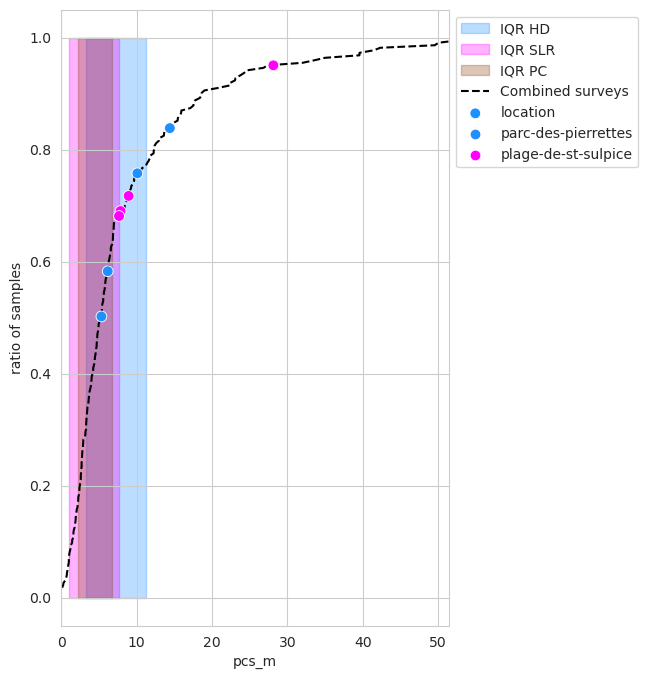

In [29]:
boi = ["plage-de-st-sulpice","parc-des-pierrettes"]
sp_ld = fd[fd.location.isin(boi)].groupby(["loc_date", "location"], as_index=False).pcs_m.sum()
sp_ld["p"] = sp_ld.pcs_m.map(lambda x: combined(x))

ecdfs = [ECDF(a_locdate[a_locdate.team == x].pcs_m.values) for x in ["HD", "SLR", "PC"]]

fig, ax = plt.subplots(figsize=(5,8))

ax.set_xlim(0, ylimit)


for i, name in enumerate(["HD", "SLR", "PC"]):
    somdata=ecdfs[i].x
    lower25 = np.quantile(somdata, .25)
    upper25 = np.quantile(somdata, .75)
    
    ax.fill_between([lower25, upper25], y1=0, y2=1, color=colors[i], alpha=0.3, zorder=0, label=f"IQR {name}")    
        
combined = ECDF([*ecdfs[0].x, *ecdfs[1].x, *ecdfs[2].x])
boi = ["plage-de-st-sulpice","parc-des-pierrettes"]
sp_ld = fd[fd.location.isin(boi)].groupby(["loc_date", "location"], as_index=False).pcs_m.sum()
sp_ld["p"] = sp_ld.pcs_m.map(lambda x: combined(x))

sns.lineplot(x=combined.x, y=combined.y, ax=ax, label="Combined surveys", zorder=2, linestyle="dashed", color="black")
sns.scatterplot(data=sp_ld, x="pcs_m", y="p", label="location", s=60, hue="location", palette=colors[:2], zorder=3, ax=ax)

handles, labels = ax.get_legend_handles_labels()

n_handles = handles # [*handles[-4:], *handles[:-4]] # handles
n_labels =  labels # [*labels[-4:], *labels[:-4]] # labels
ax.set_ylabel("ratio of samples")
plt.legend(n_handles, n_labels, bbox_to_anchor=(1,1), loc="upper left")
plt.show()

In [30]:
sp_ld[["location", "pcs_m", "p"]]

,location,pcs_m,p
0,parc-des-pierrettes,14.39,0.838565
1,parc-des-pierrettes,6.15,0.582960
2,parc-des-pierrettes,5.31,0.502242
3,parc-des-pierrettes,10.08,0.757848
4,plage-de-st-sulpice,28.13,0.950673
5,plage-de-st-sulpice,8.92,0.717489
6,plage-de-st-sulpice,7.85,0.690583
7,plage-de-st-sulpice,7.65,0.681614
